# Classification avec Transformer (Encoder seul)

In [13]:
# !pip install dill

In [230]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, roc_auc_score

import sys
sys.path.append('..')
from utils import *

## Chargement et prétraitement des données (seulement en anglais)

In [2]:
# toots = pd.read_csv('../data/offensive_toots.csv').dropna()[['content', 'y']]
# print('Taille des toots au début', len(toots))

# # toots pos et neg
# itoots_pos = toots['y'] == 1
# itoots_neg = toots['y'] == 0
# toots_pos = toots[itoots_pos]
# toots_neg = toots[itoots_neg]

# indices = np.array([i for i in range(len(toots_neg))])
# np.random.shuffle(indices)
# toots_neg = toots_neg.iloc[indices[:len(toots_pos)]]

# # Concaténation par lignes (axis=0)
# toots = pd.concat([toots_neg, toots_pos], axis=0, ignore_index=True)

# print(f'Nb pos: {len(toots_pos)} -- Nb neg: {len(toots_neg)} -- total: {len(toots)}')

# toots.head()

Taille des toots au début 47465
Nb pos: 1011 -- Nb neg: 1011 -- total: 2022


,content,y
0,Hazel with her herding ball. There is about 5 ...,0
1,#Earthquake (#deprem) M1.8 strikes 30 km NE of...,0
2,Here's the source code for the script that gen...,0
3,Do you consider it rude or stalky to scroll to...,0
4,"ScienceDailyScienceDaily: ""Your source for th...",0


## Prétraitement et sauvegarde des embeddings (8 minutes)

In [3]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# # Charger le modèle de tokenizer et le modèle de langue
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")

# # Obtenir les embeddings pour chaque mot de chaque phrase
# ldata = []
# MAX_LENGTH = 250
# for it in range(len(toots_pos)):
#     print(f'{it} / {len(toots_pos)}', end='\r')
#     toot = toots.iloc[it]
#     phrase = toot['content']
#     y = toot['y']
    
#     # Obtenir les embeddings des tokens
#     embeddings = model(torch.tensor([tokenizer.encode(phrase)[:MAX_LENGTH]]))[0]
    
#     ldata.append((embeddings, y))

# save_object('../data/offensive_toots_emb_pos.dill', ldata)


Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


In [4]:

# # Obtenir les embeddings pour chaque mot de chaque phrase
# ldata = []
# MAX_LENGTH = 250
# for it in range(len(toots_neg)):
#     print(f'{it} / {len(toots_neg)}', end='\r')
#     toot = toots.iloc[it]
#     phrase = toot['content']
#     y = toot['y']
    
#     # Obtenir les embeddings des tokens
#     embeddings = model(torch.tensor([tokenizer.encode(phrase)[:MAX_LENGTH]]))[0]
    
#     ldata.append((embeddings, y))

# save_object('../data/offensive_toots_emb_neg.dill', ldata)


## Charger les embeddings déjà prétraités et enregistrés

deux fichiers embed pos et neg pour ça tienne en mémoire: 
- '../data/offensive_toots_emb_pos.dill'
- '../data/offensive_toots_emb_neg.dill'

In [208]:
ldata_pos = load_object('../data/offensive_toots_emb_pos.dill')
ldata_neg = load_object('../data/offensive_toots_emb_neg.dill')
ldata = ldata_pos + ldata_neg
ldata = [(embs.squeeze(dim=0), torch.tensor([0,1], dtype=torch.float32) ) for embs,y in ldata_pos] + \
  [(embs.squeeze(dim=0), torch.tensor([1,0], dtype=torch.float32) ) for embs,y in ldata_neg]

# shuffle
indices = np.array([i for i in range(len(ldata))])
np.random.shuffle(indices,)

ldata2 = [ldata[i] for i in indices]
ldata = ldata2

## DataLoader

In [268]:
class MyData(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

dataset = MyData(ldata)

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
def collate_batch(batch):
  lembs, labels = zip(*batch)
  
  padded_embs = pad_sequence(lembs, batch_first=True, padding_value=0)

  # Ajoutez du padding à droite avec des vecteurs remplis de zéros pour atteindre la longueur maximale
  max_seq_length = max(len(seq) for seq in lembs)
  padded_embs = torch.nn.functional.pad(padded_embs, (0, 0, 0, max_seq_length - padded_embs.size(1)))

  # Le résultat sera un tensor de taille (batch_size, max_sequence_length, 768)
  return padded_embs, torch.stack(labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

In [225]:
class Net(nn.Module):
  def __init__(self, dim=768, emb_dim=384, hidden_size=120):
    super(Net, self).__init__()
    
    # MLP pour les apprendre de nouv embeds 768 -> 384
    self.to_embs = nn.Sequential(
      nn.Linear(dim, emb_dim)
    )
    self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, num_layers=2)
    self.hidden2label = nn.Linear(hidden_size,2)
  
  def forward(self, x):
    embeds = self.to_embs(x)
    lstm_out, _ = self.lstm(embeds)
    last_out = lstm_out[:, -1, :]
    label_space = self.hidden2label(last_out)
    label_scores = F.softmax(label_space, dim=1)
    return label_scores


In [217]:
def f1score(y_true, y_pred):
  epsilon=1e-7
  # Calculez les vrais positifs, faux positifs et faux négatifs
  tp = torch.sum(y_true * y_pred)
  fp = torch.sum((1 - y_true) * y_pred)
  fn = torch.sum(y_true * (1 - y_pred))

  # Calculez la précision, le rappel et le F1 score
  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
  f1 = 2 * (precision * recall) / (precision + recall + epsilon)

  return f1

def balanced_accuracy(lyhat, ly):
  lyhat, ly = torch.tensor(lyhat), torch.tensor(ly)

  ipos, ineg = ly == 1, ly == 0
  ly_pos, ly_neg = ly[ipos], ly[ineg]
  lyhat_pos, lyhat_neg = lyhat[ipos], lyhat[ineg]

  tp = (lyhat_pos == ly_pos).sum()
  tn = (lyhat_neg == ly_neg).sum()
  
  sensitive_p = tp / len(ly_pos)
  sensitive_n = tn / len(ly_neg)

  ba = (sensitive_p + sensitive_n) / 2
  
  return ba

def raucAuc(self, lyhat, ly):
  # Convertir les listes en tenseurs PyTorch
  predictions_prob = torch.tensor(predictions_prob)
  targets = torch.tensor(targets)

  # Utiliser scikit-learn pour calculer l'aire sous la courbe ROC (ROC-AUC)
  roc_auc = roc_auc_score(np.array(lyhat), np.array(ly))

  return roc_auc


In [274]:
def apprentissage(net, criterion, optimizer, train_dl, test_dl, epochs):
  train_loss, test_loss = [], []
  for epoch in range(epochs):
    print(f"Epoch [{(epoch+1):4d}/{epochs:4d}] ")
    lep = []
    net.train()
    for batch_idx, (batch, y) in enumerate(train_dl):

      yhat = net(batch)
      loss = criterion(y, yhat)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # save loss train
      lep.append(loss.detach().numpy())
      
      print(
        f"\ttrain batch [{(batch_idx+1):4d}/{len(train_dl):4d}] - "
        f"Loss : {lep[-1]:.4f} ", end="\r"
      )
    print(
      f"\ttrain batch [{(batch_idx+1):4d}/{len(train_dl):4d}] - "
      f"Loss : {lep[-1]:.4f} "
    )
    train_loss.append(np.mean(lep))
    
    lep = []
    net.eval()
    for batch_idx, (batch, y) in enumerate(test_dl):

      yhat = net(batch)
      loss = criterion(y, yhat)
      lep.append(loss.detach().numpy())
      
      print(
        f"\ttest batch [{(batch_idx+1):4d}/{len(test_dl):4d}] - "
        f"Loss : {lep[-1]:.4f} ", end="\r"
      )
    print(
      f"\ttest batch [{(batch_idx+1):4d}/{len(test_dl):4d}] - "
      f"Loss : {lep[-1]:.4f} "
    )
    test_loss.append(np.mean(lep))
  
  return train_loss, test_loss

def prediction(net, dl):
  net.eval()
  lyhat, ly = [], []
  for batch_idx, (batch, y) in enumerate(dl):
    
    yhat = net(batch)
    
    labels = torch.argmax(y, dim=1) # [0,1] pos et [1,0] neg
    preds  = torch.argmax(yhat, dim=1) # arg1 pos
    
    ly.extend(labels)
    lyhat.extend(preds)

  lyhat, ly = torch.vstack(lyhat).squeeze(), torch.vstack(ly).squeeze()
  print('y', torch.bincount(ly))
  print('yhat', torch.bincount(lyhat))

  ipos, ineg = ly == 1, ly == 0
  ly_pos, ly_neg = ly[ipos], ly[ineg]
  lyhat_pos, lyhat_neg = lyhat[ipos], lyhat[ineg]

  print(f'Taux de prediction total: {(100*((lyhat == ly).sum()/ len(ly))):.2f}%')
  print(f'Taux de prediction sur les pos: {(100*((lyhat_pos == ly_pos).sum()/ len(ly_pos))):.2f}%')
  print(f'Taux de prediction sur les neg: {(100*((lyhat_neg == ly_neg).sum()/ len(ly_neg))):.2f}%')
  
  f1_sc_pos = f1score(ly, lyhat)
  f1_sc_neg = f1score(1-ly, 1-lyhat)
  print(f'F1 score (positifs): {(100*f1_sc_pos):.2f}%')
  print(f'F1 score (négatifs): {(100*f1_sc_neg):.2f}%')
  
  f1_macro_loss = (f1_sc_pos + f1_sc_neg) / 2
  print(f'f1 macro score : {(100*f1_macro_loss):.2f}%')

  # scores
  tp = (lyhat_pos == ly_pos).sum()
  tn = (lyhat_neg == ly_neg).sum()
  fp = (lyhat_pos != ly_pos).sum()
  fn = (lyhat_neg != ly_neg).sum()

  accuracy_score = (tp + tn) / (tp + tn + fp + fn)
  precision_score = tp / (tp + fp)
  recall_score = tp / (tp + fn)
  f1_score = 2*precision_score*recall_score / (precision_score + recall_score)

  print(f'\naccuracy score: {(100*accuracy_score):.2f}%')
  print(f'precision score: {(100*precision_score):.2f}%')
  print(f'recall score: {(100*recall_score):.2f}%')
  print(f'f1 score: {(100*f1_score):.2f}%')
  
  return lyhat


## Apprentissage

In [275]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epochs = 3

In [276]:
train_loss, test_loss = apprentissage(net, criterion, optimizer, train_loader, test_loader, epochs)

Epoch [   1/   3] 
	train batch [  26/  26] - Loss : 0.8225 
	test batch [   7/   7] - Loss : 0.8125 
Epoch [   2/   3] 
	train batch [  26/  26] - Loss : 0.8111 
	test batch [   7/   7] - Loss : 0.8133 
Epoch [   3/   3] 
	train batch [  26/  26] - Loss : 0.8114 
	test batch [   7/   7] - Loss : 0.8113 


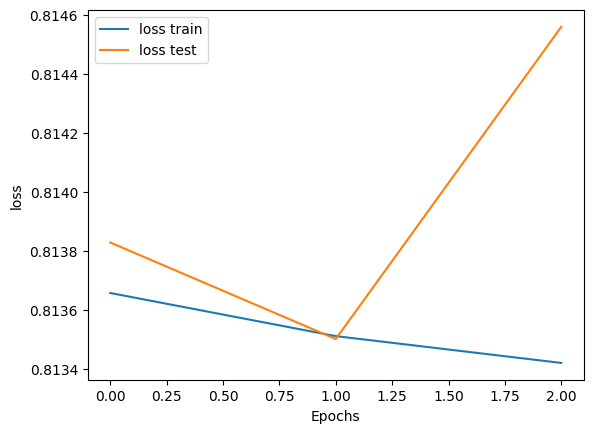

In [228]:
plt.plot(train_loss, label='loss train')
plt.plot(test_loss, label='loss test')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Taux de bonnes prédiction dans train

### Taux de bonnes prédiction dans test

In [229]:
lyhat = prediction(net, test_loader)

y tensor([208, 196])
yhat tensor([  0, 404])
Taux de prediction total: 48.51%
Taux de prediction sur les pos: 100.00%
Taux de prediction sur les neg: 0.00%
F1 score (positifs): 65.33%
F1 score (négatifs): 0.00%
f1 macro score : 32.67%

accuracy score: 48.51%
precision score: 100.00%
recall score: 48.51%
f1 score: 65.33%
